Github repo for Everything counts assesment 1 - https://github.com/ganeshk-lis/ec-a01

The dataset for this project is **aei_enriched_claude_ai_2025-08-04_to_2025-08-11.csv**
It [1] is an enriched dataset from Anthropic Economic index release_2025_09_15 which contains Claude AI usage metrics between 2025/08/04 and 2025/08/11 by geography (worldwide and US states) and other analysis dimensions called facets. The raw dataset, other preprocessing scripts and the above enriched dataset are available at https://huggingface.co/datasets/Anthropic/EconomicIndex/blob/main/release_2025_09_15 [1]
 

The preprocessing scripts add contry codes, per capita usage and whether Claude AI usage is automation or collaboration. They also compare prompts to O\*NET US government database [2] to create a mapping between user prompts and standard occupation list.
For e.g. a prompt such as 'help me debug this code' will be mapped with Software Developers (15-1252.00) job code which includes the text *Modify existing software to correct errors, adapt it to new hardware, or upgrade interfaces and improve performance.*
https://www.onetonline.org/link/summary/15-1252.00

In [28]:
# Let's load the dataset and look at the structure
import pandas as pd
df = pd.read_csv('aei_enriched_claude_ai_2025-08-04_to_2025-08-11.csv')
print(f'Dataset contains {df.shape[0]} rows (entries) and {df.shape[1]} columns')
print('The columns in data are:')
for i, column in enumerate(df.columns):
    print(f'{i+1}. {column}')

Dataset contains 136845 rows (entries) and 11 columns
The columns in data are:
1. geo_id
2. geography
3. date_start
4. date_end
5. platform_and_product
6. facet
7. level
8. variable
9. cluster_name
10. value
11. geo_name


In [24]:
# Lets check first few rows
df.head()

,geo_id,geography,date_start,date_end,platform_and_product,facet,level,variable,cluster_name,value,geo_name
0,ABW,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,gdp_per_working_age_capita,NaN,55553.993646,Aruba
1,ABW,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_count,NaN,0.000000,Aruba
2,ABW,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_pct,NaN,0.000000,Aruba
3,ABW,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_per_capita,NaN,0.000000,Aruba
4,ABW,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_per_capita_index,NaN,0.000000,Aruba


*usage_count* in variable refers to number of conversations in a particular geography and *usage_per_capita* refers to number of conversations divided by working age population (15-64) of that geography. Thus *usage_per_capita* normalises number of Claude AI conversations for population difference between regions.

This dataset was selected for AI usage metrics. For this exercise let's analyse country level Claude AI usage.
Let's extract country level variables *usage_per_capita* and also add *gdp_per_working_age_capita*. Remove US state data for this analysis.

In [29]:
country_usage = df[
    (df['variable'].isin(['usage_per_capita', 'gdp_per_working_age_capita'])) & # filter for usage_per_capita & gdp_per_working_age_capita
    (df['facet'] == 'country') # filter for country level data
]
# So our new dataframe looks like below
country_usage.head()

,geo_id,geography,date_start,date_end,platform_and_product,facet,level,variable,cluster_name,value,geo_name
0,ABW,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,gdp_per_working_age_capita,NaN,55553.993646,Aruba
3,ABW,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_per_capita,NaN,0.000000,Aruba
23,AGO,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,gdp_per_working_age_capita,NaN,5796.591077,Angola
28,AGO,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_per_capita,NaN,0.000012,Angola
73,ALB,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,gdp_per_working_age_capita,NaN,15160.177658,Albania


As we are interested in country wise usage, let's use *geo_id*(country) as index and make *usage_per_capita* and *gdp_per_working_age_capita* as columns. So we are flattening the above dataframe where 'value' becomes corresponding column value for *usage_per_capita* and *gdp_per_working_age_capita*.

In [30]:
country_usage_adjusted = country_usage.pivot(
    index=['geo_id', 'geo_name'],
    columns='variable', 
    values='value'
).reset_index()

# So our adjusted dataframe looks like below
country_usage_adjusted

variable,geo_id,geo_name,gdp_per_working_age_capita,usage_per_capita
0,ABW,Aruba,55553.993646,0.000000
1,AGO,Angola,5796.591077,0.000012
2,ALB,Albania,15160.177658,0.000206
3,AND,Andorra,68285.588663,0.000676
4,ARE,United Arab Emirates,60127.058783,0.000337
...,...,...,...,...
189,WSM,Samoa,8801.859269,0.000000
190,XKX,Kosovo,10548.291708,0.000112
191,ZAF,South Africa,9272.848441,0.000119
192,ZMB,Zambia,2182.304944,0.000030


We have data for 194 countries

In [31]:
# descriptive statistics for usage_per_capita
stats = country_usage_adjusted['usage_per_capita'].describe()
stats

count    194.000000
mean       0.000244
std        0.000291
min        0.000000
25%        0.000029
50%        0.000120
75%        0.000345
max        0.001827
Name: usage_per_capita, dtype: float64

In [32]:
#  Lets plot median, mean, standard deviation, 75th pecentile
median = country_usage_adjusted['usage_per_capita'].median()
mean = stats['mean']
std_dev = stats['std']
quantile_75 = stats['75%']
max_value = stats['max']

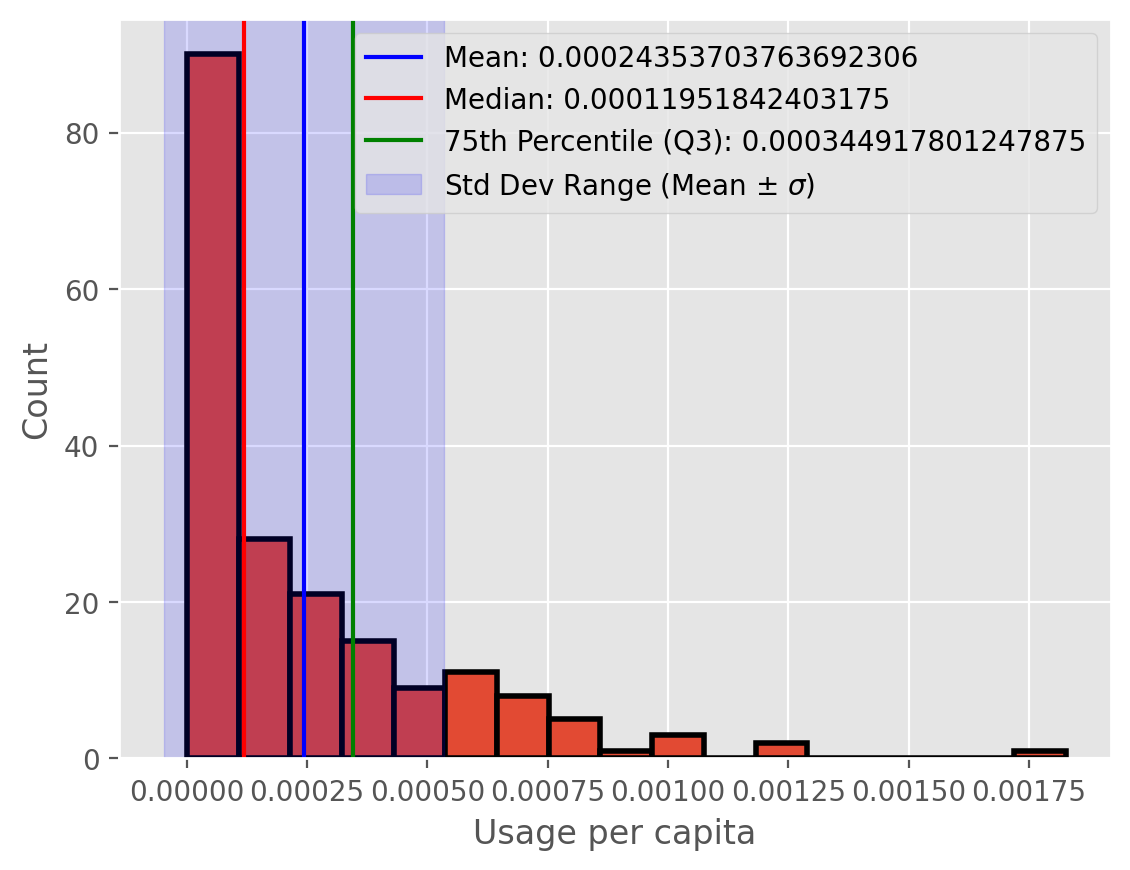

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

plt.hist(country_usage_adjusted['usage_per_capita'], bins = 'auto', edgecolor = 'black', linewidth = 2)
plt.axvline(mean, color='blue', label=f'Mean: {mean}')
plt.axvline(median, color='red', label=f'Median: {median}')
plt.axvline(quantile_75, color='green', label=f'75th Percentile (Q3): {quantile_75}')
plt.axvspan(mean - std_dev, mean + std_dev, color='blue', alpha=0.15, label='Std Dev Range (Mean ± $\sigma$)')
plt.xlabel('Usage per capita')
plt.ylabel('Count')
plt.legend()
plt.show();

In [36]:
print(f'median = {median}, mean = {mean}')
if mean > median:
    print('Mean is higher than median which means few countries dominate the usage')

print(f'Top 25% is from {quantile_75} and max value is {max_value}')
print(f'This difference between max value and 75th percentile means the distribution has a long tail')

#  Above plot shows most countries have very low usage.


median = 0.00011951842403175, mean = 0.00024353703763692306
Mean is higher than median which means few countries dominate the usage
Top 25% is from 0.000344917801247875 and max value is 0.0018270215841033
This difference between max value and 75th percentile means the distribution has a long tail


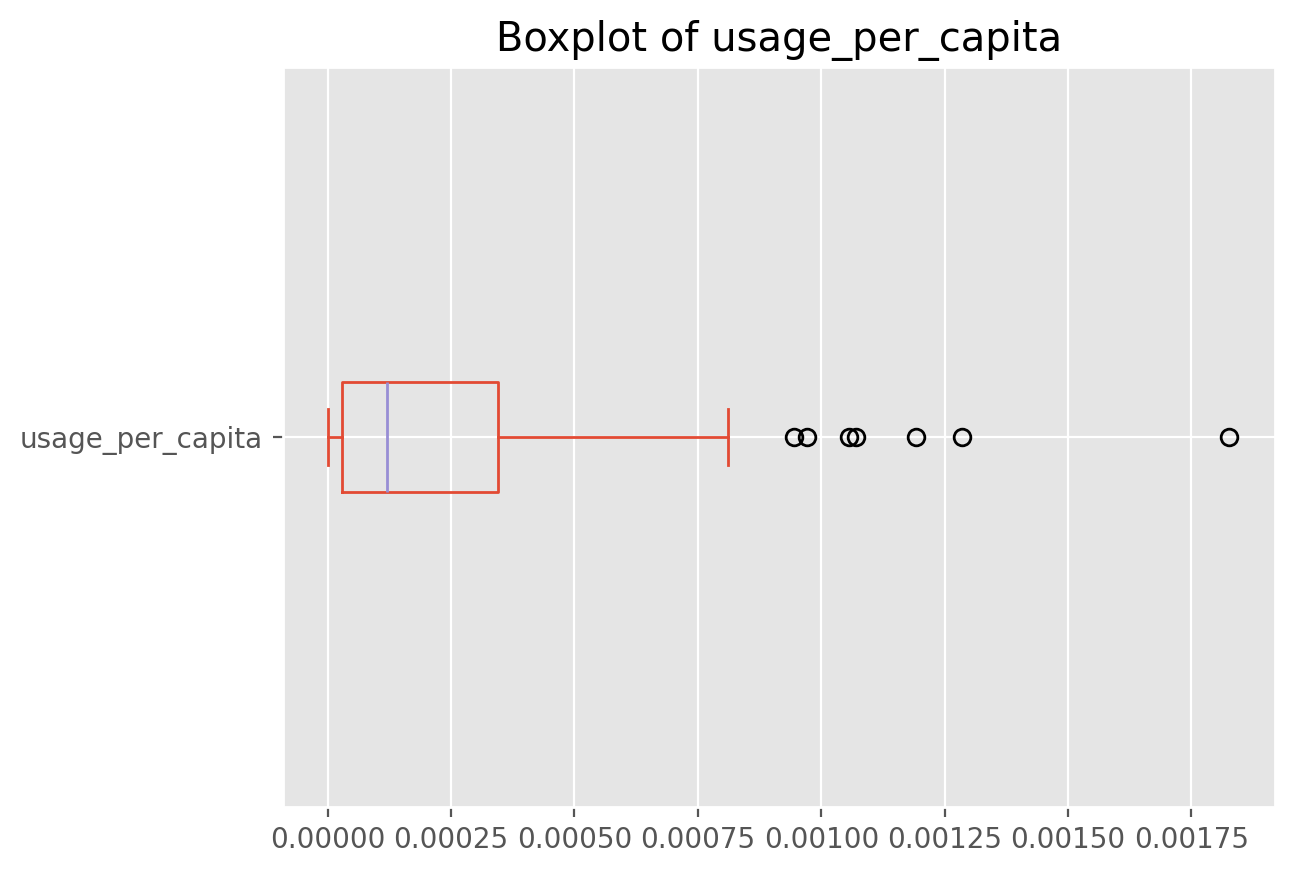

In [ ]:
# A box plot visualisation will be useful to see the outliers
country_usage_adjusted['usage_per_capita'].plot(kind = 'box', vert=False, title = 'Boxplot of usage_per_capita')
plt.show(); 

The black circles are the outliers which lie on far right and box is skewed to the left. 
This shows low AI usage amongst most countries with few outliers of heavy usage

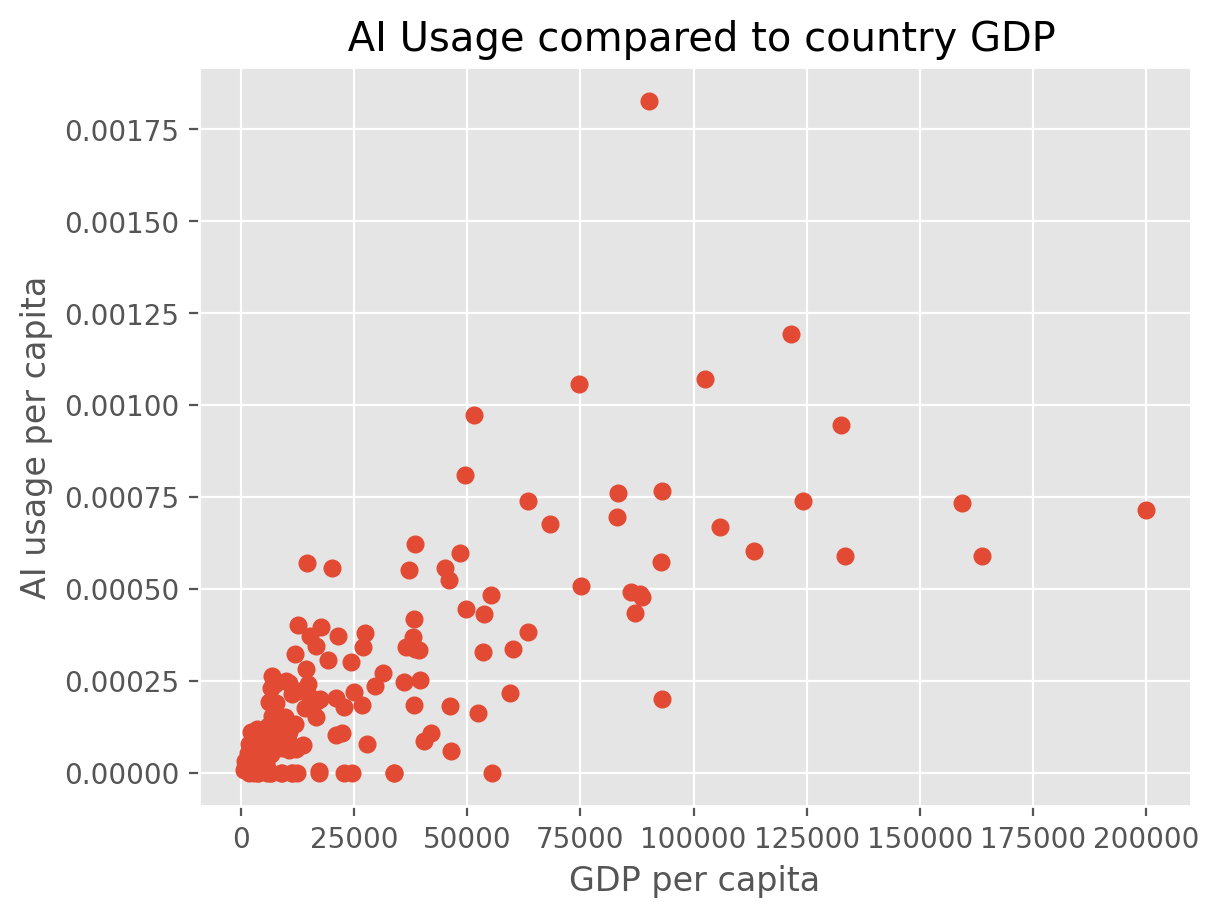

In [39]:
# A correlation between GDP of country and claude AI usage
y_axis = country_usage_adjusted['usage_per_capita']
x_axis = country_usage_adjusted['gdp_per_working_age_capita']
plt.scatter(x_axis, y_axis)
plt.title(' AI Usage compared to country GDP')
plt.xlabel('GDP per capita')
plt.ylabel('AI usage per capita' )
plt.show()

We see most of the points are bunched on the lower left which shows low Claude AI usage in countries with low GDP.



**References:**

[1]R. Appel, P. McCrory, A. Tamkin, M. Stern, M. McCain, and T. Neylon, “Anthropic Economic Index Report: Uneven Geographic and Enterprise AI Adoption,” Sep. 15, 2025. www.anthropic.com/research/anthropic-economic-index-september-2025-report

[2]“About O\*NET at O\*NET Resource Center.” https://www.onetcenter.org/overview.html